In [1]:
########## SECTION 1 - Importing Required Packages and Functions ###############################
import pandas as pd
import numpy as np 
import time
from simulate import generateData
from linear_programs import checkMleExistence

In [2]:
########## SECTION 2 - Generating Simulated Dataset ############################################

# number of observations
n=4000

# number of (Gaussian) covariates
p=20

# signal strength
signal_strength = 5

# Parameters for Distribution to draw Betas from. Betas ~ N(mu, stdev^2)
mu = 0
stdev = 1.0

# Generate the data
# - X is an (n,p+1) dimensional array with the n rows corresponding to observations and the p+1 columns
#   corresponding to the covariates + a column of 1's (for the intercept term)
# - Beta is the (p+1,) dimensional array of 'True' regression coefficients
# - y is the (n,) dimensional array of response values for the observations
# - means is the (n,) dimensional array of predicted values (probabilities in case of logistic)
# *THOUGHT: Perhaps we could use another term instead of means to avoid confusion with the systematic component?
# * perhaps y_hat, preds, etc?
X, Beta, y, means = generateData(dist = 'bernoulli', n = n, p = p, mu = mu, stdev = stdev, signal_strength = signal_strength) 

In [3]:
# Sanity Check 1: Should be equal to signal strength
Beta.dot(Beta)/n

4.999999999999999

In [4]:
# Sanity check 2 - Ignore
#from simulate import generateRandomBeta
#beta = generateRandomBeta(q=p, mu=mu, stdev=stdev)
#bb = beta * np.sqrt( (n * signal_strength) / beta.T.dot(beta).values[0,0] )
#bb.values.T.dot(bb.values)/n # check

In [5]:
# Combining the predictor and response data into a single pandas dataframe df
df = pd.DataFrame(X)
y = np.array(y)
y = np.where(y>0,1,-1)# Changed label 0 to -1, For convenience, we choose the label as {-1,1} instead of {0,1}
df['y'] = pd.Series(y)

(array([79., 97., 80., 62., 68., 75., 55., 46., 62., 44., 54., 43., 47.,
        45., 37., 39., 53., 41., 38., 30., 29., 33., 26., 29., 34., 32.,
        51., 26., 24., 32., 27., 30., 31., 31., 35., 29., 29., 30., 32.,
        26., 18., 18., 25., 23., 24., 30., 29., 29., 34., 24., 32., 37.,
        22., 25., 26., 16., 26., 29., 31., 34., 32., 34., 29., 24., 27.,
        24., 35., 31., 34., 36., 36., 28., 31., 35., 34., 35., 33., 30.,
        30., 33., 34., 36., 50., 37., 41., 42., 55., 46., 57., 38., 49.,
        42., 54., 66., 68., 82., 70., 90., 82.]),
 array([2.48925582e-04, 1.02430594e-02, 2.02371932e-02, 3.02313270e-02,
        4.02254609e-02, 5.02195947e-02, 6.02137285e-02, 7.02078623e-02,
        8.02019961e-02, 9.01961300e-02, 1.00190264e-01, 1.10184398e-01,
        1.20178531e-01, 1.30172665e-01, 1.40166799e-01, 1.50160933e-01,
        1.60155067e-01, 1.70149201e-01, 1.80143334e-01, 1.90137468e-01,
        2.00131602e-01, 2.10125736e-01, 2.20119870e-01, 2.30114003e-01,
       

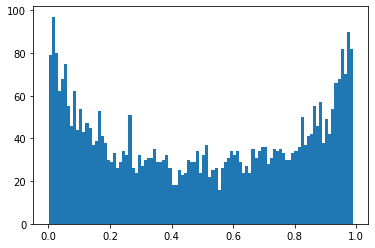

In [6]:
# QUICK ASIDE...
# Looking at distribution of means
import matplotlib.pyplot as plt
min_mean = min(means)
max_mean = max(means)
plt.hist(means, bins=np.arange(min_mean, max_mean, (max_mean-min_mean)/100))

(array([  1.,   1.,   0.,   0.,   0.,   0.,   0.,   2.,   1.,   1.,   1.,
          1.,   2.,   5.,   4.,   5.,   5.,   5.,   6.,   6.,  10.,  15.,
         11.,  17.,  26.,  19.,  30.,  28.,  33.,  28.,  40.,  42.,  47.,
         63.,  57.,  53.,  82.,  68.,  75.,  82.,  91., 100.,  80.,  78.,
        120.,  92., 110., 118.,  94., 102., 115., 121.,  97., 123.,  99.,
        120., 109., 106.,  88.,  89.,  97.,  90.,  91.,  82.,  67.,  55.,
         65.,  64.,  55.,  61.,  43.,  41.,  39.,  31.,  32.,  17.,  14.,
         29.,  17.,  13.,  13.,  13.,   7.,   9.,  11.,   2.,   3.,   3.,
          1.,   3.,   0.,   2.,   2.,   0.,   0.,   2.,   1.,   0.,   0.]),
 array([-8.29810762, -8.13519617, -7.97228472, -7.80937328, -7.64646183,
        -7.48355038, -7.32063893, -7.15772749, -6.99481604, -6.83190459,
        -6.66899315, -6.5060817 , -6.34317025, -6.1802588 , -6.01734736,
        -5.85443591, -5.69152446, -5.52861302, -5.36570157, -5.20279012,
        -5.03987867, -4.87696723, -4.714

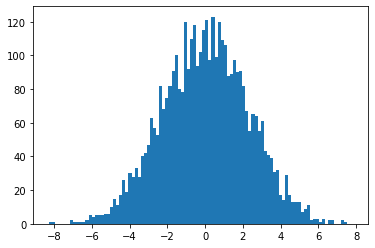

In [7]:
# Looking at distribution of systematic components (would prefer to call these the "means")
sys = X.dot(Beta)
min_sys = min(sys)
max_sys = max(sys)
plt.hist(sys, bins=np.arange(min_sys, max_sys, (max_sys-min_sys)/100))

In [8]:
# Checking percentiles of 'sys'. For signal strength of 5, 2.5th percentile should be > ~-4.472
# and 97.5th percentile should be < ~4.472
print(' 2.5th percentile: '+str(np.percentile(sys,2.5)))
print('97.5th percentile: '+str(np.percentile(sys,97.5)))

 2.5th percentile: -4.378841398969048
97.5th percentile: 4.435060021295694


In [9]:
########## SECTION 3 -  ############################################
########## SECTION 2 - Generating Simulated Dataset ############################################

# Given a data sample (y_i, X_i), start by choosing a "fine grid" of kappas <= 1/2
kappaArray = np.arange(0.1,0.51,0.01) # CHANGED TO SMALLEST VALUE TO 0.1

# Initializing list to hold proportions of times MLE *** does not **** exist at each kappa
kappaProportion = []

d1 = time.time()

# For each k_j in the grid, we do the following:
for kappa in kappaArray:
    
    # Set sample size to n_j =p / k_j (rounding off to nearest integer)
    # NOTE: FOR LARGE P THERE MAY NOT BE ENOUGH SAMPLES FOR SMALL KAPPA!
    sampleSize = int(round(p/kappa))

    # Here, we draw several samples and check to see if the MLE exists. B is the number of
    # rounds of sampling
    B = 5
    
    # nMleDNE is the total number of times the MLE *** Does Not Exist *** for each kappa (k_j). This
    # is initially set to 0
    nMleDNE = 0
    for i in range(B):
        subSample = df.sample(n=sampleSize) # draw the sample
        subSample =subSample.reset_index(drop = True) # Reindexing is necessary because df.sample draws 
                                                        # the originial index from the dataframe
        
        mleStatus = checkMleExistence(subSample) # check if MLE exists
        # Note that checkMleExistence returns a coded value. The list of coded values can be
        # found here: https://www.gurobi.com/documentation/9.0/refman/optimization_status_codes.html
        # We are most interested in the number of times (out of B times) MLE does not exist.
        # If MLE does not exist, the checkMleExistence function will return status code 2 indicating that the 
        # LP has an optimal solution. 
        
        if mleStatus == 2:
            nMleDNE +=1
            
    # Dividing nMleExist by B gives an estimate of the proportion of times the MLE exists.
    propMleDNE = nMleDNE/B
    kappaProportion.append(propMleDNE)
    

# Now, we need (kappa_j-1, kappa_j) such that kappa_j is the smallest value for which the proportion of times
# the MLE does not exist
uIdx = 0
for kappaProp in kappaProportion:
    if kappaProp>=0.5:
        uIdx = kappaProportion.index(kappaProp) # index of kappa_j
        break
if uIdx != 0:
    uKappa = kappaArray[uIdx] # kappa_j
    lKappa = kappaArray[uIdx-1] # kappa_j-1
else:
    print('Method Failed, All Subsamples are separable!')

d2 = time.time()
delta = round(d2 - d1)
print(kappaProportion, delta)

Using license file /home/nahid/gurobi.lic
Academic license - for non-commercial use only
Method Failed, All Subsamples are separable!
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 5
